In [13]:
# libraries
import numpy as np
import pandas as pd

from scipy.stats import norm

from chronocluster.data.simdata import generate_random_points
from chronocluster import clustering
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, plot_mc_points, get_box, chrono_plot
from chronocluster.distributions import ddelta

In [30]:
# data wrangling
df = pd.read_csv('../Data/temples_with_predicted_ages.csv')
df = df.dropna(subset=['xeast', 'ynorth', 'model_age_mean', 'model_age_sd'])
df['xeast'] = df['xeast'] - df['xeast'].min()
df['ynorth'] = df['ynorth'] - df['ynorth'].min()
df

,Unnamed: 0,id,morph,azimuth,area,trait_1,trait_2,trait_3,trait_4,trait_5,...,date,dating_notes,xlong,ylat,date_type,xeast,ynorth,date_emp,model_age_mean,model_age_sd
0,1,876,square,90.424247,90.860298,False,False,True,False,True,...,995.0,Date derived from art historical analyses of l...,103.85821,13.42621,empirical,25395.9,20010.0,995.0,995.000000,0.000000
1,2,874,square,90.000000,121.102386,False,False,False,False,True,...,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,25034.7,20014.0,889.0,889.000000,0.000000
2,3,878,square,90.000000,144.909427,False,False,True,False,True,...,889.0,Temple is included in CCC in Period 2.,NaN,NaN,empirical,25572.9,19929.0,889.0,889.000000,0.000000
3,4,933,square,90.000000,182.458280,False,False,True,False,False,...,1115.0,Temple is included in the CCC,NaN,NaN,empirical,26458.0,21919.0,1115.0,1115.000000,0.000000
4,5,973,square,90.658658,185.512325,False,False,NaN,NaN,NaN,...,1002.0,Temple is included in the CCC during Period 3.,NaN,NaN,empirical,26856.4,22265.0,1002.0,1002.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,1388,6996,NaN,NaN,NaN,NaN,NaN,True,False,True,...,1166.0,Date derived through graph-based semi-supervis...,103.77332,13.37078,graphbased,16171.0,13929.0,NaN,1060.857255,157.749918
1388,1389,7001,NaN,NaN,NaN,NaN,NaN,False,False,False,...,848.0,Date derived through graph-based semi-supervis...,103.94124,13.36301,graphbased,34370.6,12985.0,NaN,891.133185,156.131874
1389,1390,7002,NaN,NaN,NaN,NaN,NaN,True,False,False,...,934.0,Date derived through graph-based semi-supervis...,103.89110,13.33931,graphbased,28915.6,10382.0,NaN,911.943782,157.864667
1391,1392,7005,NaN,NaN,NaN,NaN,NaN,True,False,True,...,1166.0,Date derived through graph-based semi-supervis...,103.94205,13.35556,graphbased,34425.7,12167.0,NaN,1059.497828,157.196025


In [31]:
points = [
    clustering.Point(
        x=row['xeast'],
        y=row['ynorth'],
        start_distribution = ddelta(row['date_emp']) if not np.isnan(row['date_emp']) else norm(loc = row['model_age_mean'], scale = row['model_age_sd']),
        end_distribution = ddelta(1500)
    )
    for _, row in df.iterrows()
]
points

[Point(x=25395.899999999965, y=20010.0, start_distribution=ddelta(d=995.0), end_distribution=ddelta(d=1500)),
 Point(x=25034.70000000001, y=20014.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=25572.899999999965, y=19929.0, start_distribution=ddelta(d=889.0), end_distribution=ddelta(d=1500)),
 Point(x=26458.0, y=21919.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=26856.399999999965, y=22265.0, start_distribution=ddelta(d=1002.0), end_distribution=ddelta(d=1500)),
 Point(x=26225.29999999999, y=22993.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=26185.79999999999, y=22569.0, start_distribution=norm(loc=968.834803750701, scale=167.354175823925), end_distribution=ddelta(d=1500)),
 Point(x=26333.599999999977, y=21577.0, start_distribution=ddelta(d=1115.0), end_distribution=ddelta(d=1500)),
 Point(x=24087.0, y=22613.0, start_distribution=norm(loc=968.613504981728, scale=167.6366598891

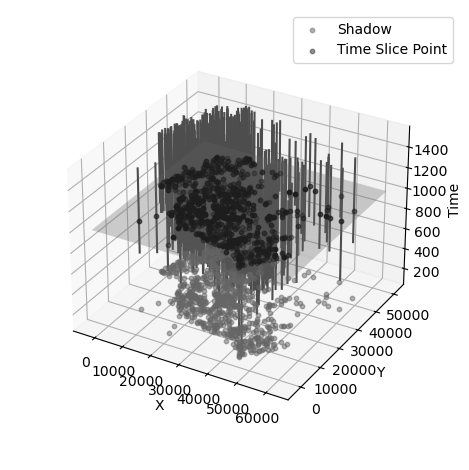

In [32]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=1000)
ax.set_box_aspect(None, zoom=0.85)

In [44]:
# Define the time slices
start_time = 800
end_time = 1200
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)

# Precompute inclusion probabilities based on age models and time slices
inclusion_probs = clustering.in_probs(points, time_slices)

# Run the Monte Carlo simulation to get an ensemble of probable
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points,
                                    time_slices,
                                    inclusion_probs,
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations,
                                                         time_slices,
                                                         bw=50,
                                                         density=False,
                                                         max_distance=max_distance)


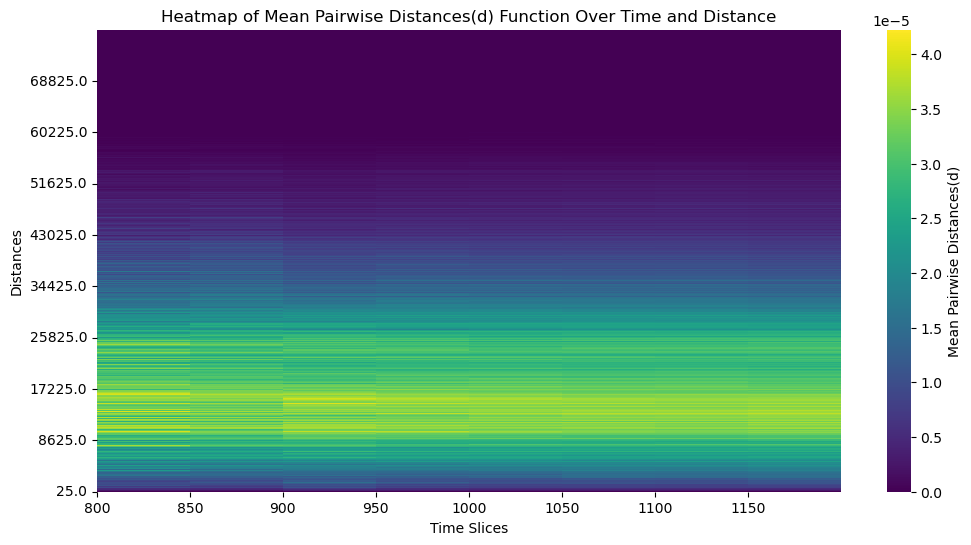

In [45]:
# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

In [46]:
# Generate CSR sample
csr_points = clustering.csr_sample(points, x_min, x_max, y_min, y_max)

# Get CSR inclusion probabilities (remember these points have the same
# temporal traits as the first simulated data)
csr_inclusion_probs = clustering.in_probs(csr_points,
                                          time_slices)

# Get MC iterations for incorporating chronological uncertainty
num_iterations = 100
csr_simulations = clustering.mc_samples(csr_points,
                                        time_slices,
                                        csr_inclusion_probs,
                                        num_iterations = num_iterations)

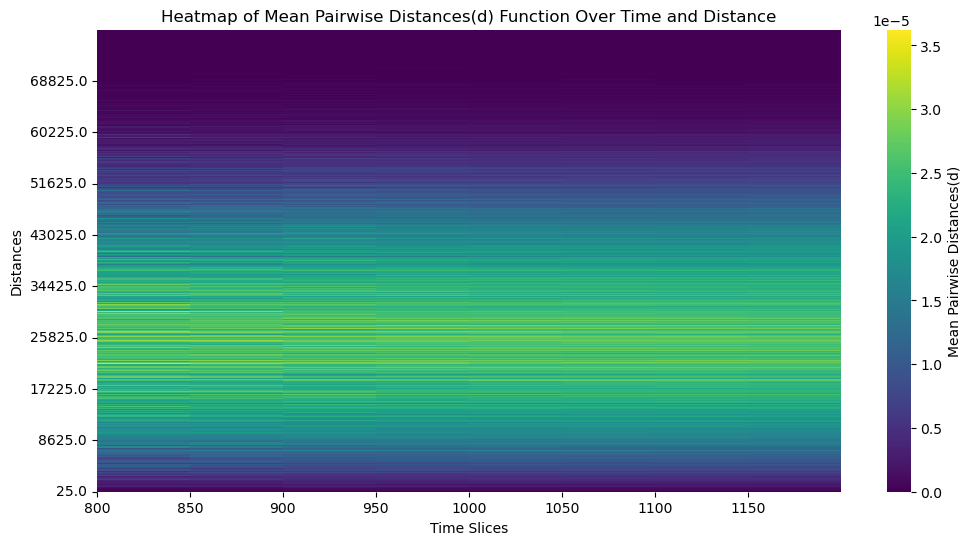

In [47]:
# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations,
                                                                 time_slices,
                                                                 bw = 50,
                                                                 density = False,
                                                                 max_distance = max_distance)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

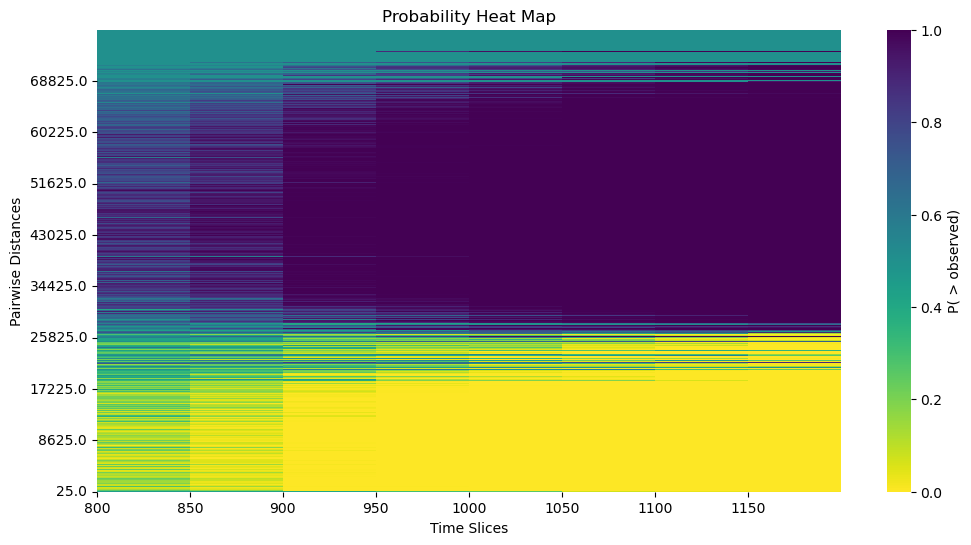

In [48]:
# Calculate the p-values for density differences between the observed points and
# the simulated CSR baseline per distance and temporal slice
p_diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)
